### Individuazione dell'impulso negli esperimenti con materiale omogeneo, in particolare sul ferro. (No attenuazione?)
##### Prima picking sull'onda, direi che basta un sta/lta. Poi:
####  Misura della velocita' e della sua incertezza, data l'incertezza sul cammino percorso e sul picking 
#### attenuazione dell'ampiezza: studiare se e' solo geometrical spreading o anche
#### perdita delle alte frequenze

In [1]:
import numpy as np
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))

from file_io import *
from plotting import *
from helpers import *
from synthetic_data import *
from signal_processing import *
from LAB_UW_forward_modeling import *


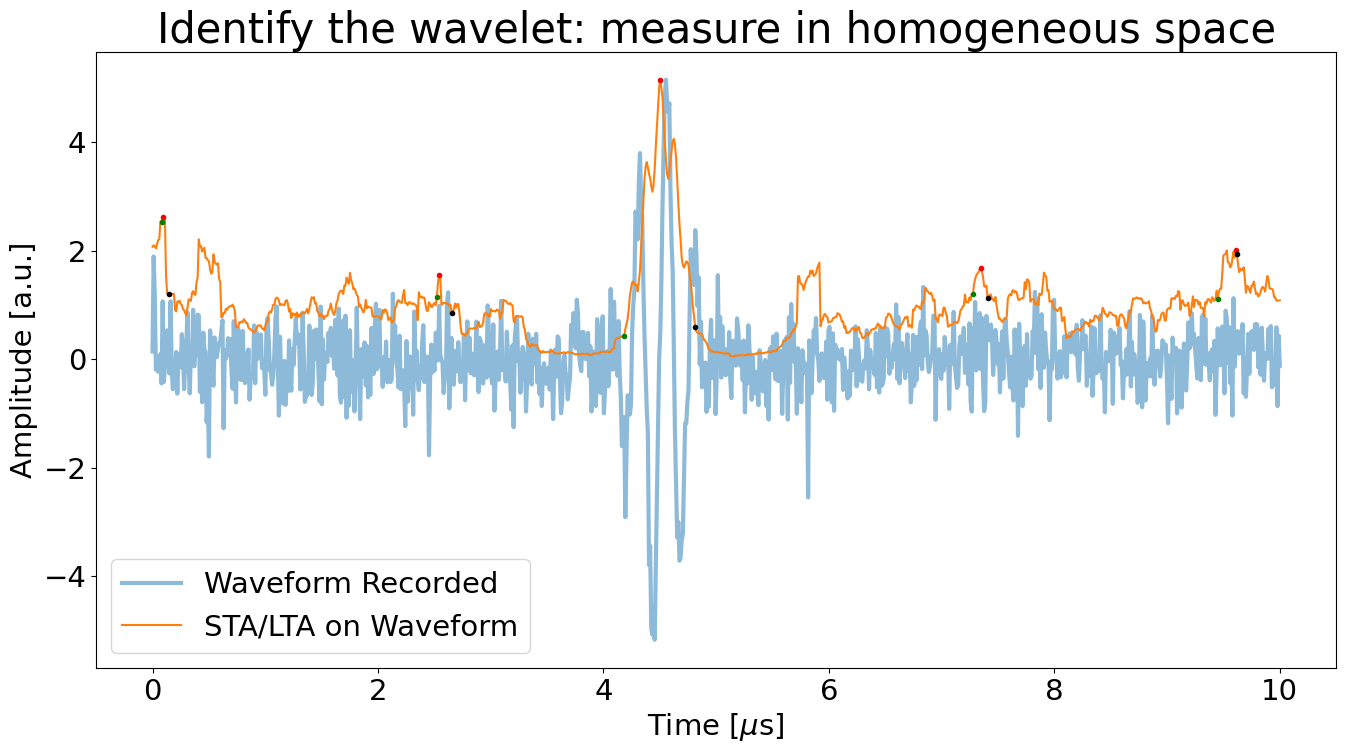

In [2]:

# Example usage of sta/lta
# Generate a synthetic signal and check the right sta_window and lta_window to maximize the ratio
# We already know the feature of the signal we want to see, and we can accordingly choose the sta/lta windows

nsamples = 1000
time = np.linspace(0, 10, nsamples)
waveform = synthetic_wavelets_in_noise()

# Compute STA/LTA ratio
sta_window = 20        # best theoretical choice: twice the sinusoidal frequency
lta_window = 200       # best theoretical choice: twice the winlen of the hanning window
ratio = sta_lta(waveform, sta_window, lta_window)

# Identify the wavelets from the sta/lta ratio of the signal recorded
index_max_list, index_min_before_list, index_min_after_list = select_wavelets_given_known_numbers_of_them(ratio, chunk_n=5, tolerance=1 )
wavelet_selection_plot(time, waveform,ratio, index_max_list, index_min_before_list, index_min_after_list)



In [3]:
# Try on real data
machine_name = "on_bench"
experiment_name = "glued_pzt"
data_type = "data_tsv_files"
remove_initial_samples = 50    # number of samples to be removed at the beginning, to get rid of the noise burst.

# qualche modifica ha reso questa funzione non funzionante (ahah)
# infile_path_list = sorted(make_infile_path_list(machine_name,experiment_name, data_type=data_type))
wavelet_directory = "/home/michele/Desktop/Dottorato/active_source_implementation/experiments_on_bench/glued_pzt/data_tsv_files"
infile_path_list = sorted(os.listdir(wavelet_directory))
infile_name = infile_path_list[7]
infile_path = os.path.join(wavelet_directory, infile_name)
print(infile_path)   


/home/michele/Desktop/Dottorato/active_source_implementation/experiments_on_bench/glued_pzt/data_tsv_files/PIS1_PIS2_glued_250ns.bscan.tsv


PROCESSING UW DATA IN /home/michele/Desktop/Dottorato/active_source_implementation/experiments_on_bench/glued_pzt/data_tsv_files/PIS1_PIS2_glued_250ns.bscan.tsv: 


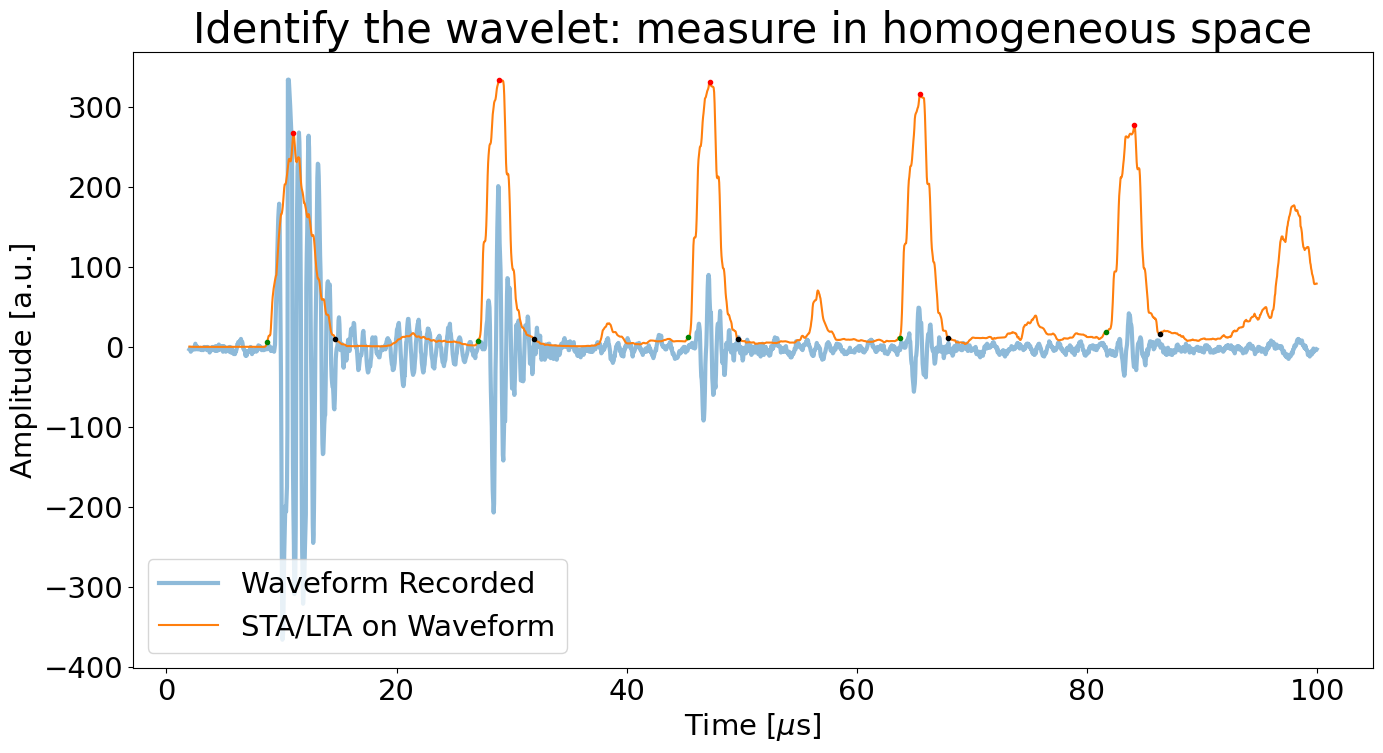

In [4]:

print('PROCESSING UW DATA IN %s: ' %infile_path)

data,metadata = make_UW_data(infile_path)
data,metadata = remove_starting_noise(data, metadata, remove_initial_samples)
x_ax = metadata['time_ax_waveform']

# windows must be:
sta_window = 2*ceil(1/ metadata['sampling_rate'])         # twice the number of samples of the pzt wavelet that is, its resonance frequency
lta_window = 2*ceil(8/ metadata['sampling_rate'])         # twice the number of samples of the wavelets train
number_of_wavelet = 5                                       # it can be calculated by length of the sample and theoretical reasoning on velocity boundary

waveform = data[4,:]
# for waveform in data:
ratio = sta_lta(waveform, sta_window, lta_window)
index_max_list, index_min_before_list, index_min_after_list = select_wavelets_given_known_numbers_of_them(ratio, 
                                                                                                          chunk_n=number_of_wavelet, 
                                                                                                          tolerance=0.2)
wavelet_selection_plot(x_ax, waveform,ratio, index_max_list, index_min_before_list, index_min_after_list)


In [8]:

# COLLECT THE PULSES WAVEFORM: they are going to be used in the forward modeling
infile_name = infile_name.split(".")[0]
data_type = [f"wavelets_from_{infile_name}"]
# anche questa riga non va piu: nel percorso c'e' un "lab_uw" di troppo. Errore stupido, ma lo sistemo dopo
# outdir_path_data = make_data_analysis_folders(machine_name = machine_name, experiment_name=experiment_name, data_types=data_type)


for choosen_wavelet in range(number_of_wavelet):
    # CHOOSE THE FILE NAME WHERE TO SAVE WAVEFORMS AND THEIR METADATA 
    outfile_name = f"wavelet_number_{choosen_wavelet}"
    outfile_path = os.path.join(outdir_path_data[0],outfile_name)

    # DEFINE wavelet DATA
    start_wavelet = index_min_before_list[choosen_wavelet]
    end_wavelet = index_min_after_list[choosen_wavelet]
    wavelet = waveform[start_wavelet:end_wavelet]

 
    # DEFINE wavelet METADATA: HEREDITATE METADATA AND UPDATE IT
    wavelet_metadata = metadata.copy()         # copy is needed, otherwise both will point to the same memory!!!
    wavelet_metadata['number_of_samples'] = len(wavelet)
    wavelet_metadata['number_of_waveforms'] = 1
    wavelet_metadata['time_ax_waveform'] = metadata['time_ax_waveform'][start_wavelet:end_wavelet]

    save_waveform_json(data = wavelet, metadata = wavelet_metadata, outfile_path = outfile_path)


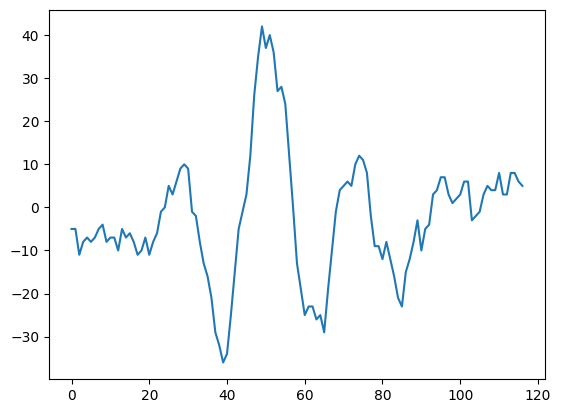

In [6]:
# Try to Load data from a JSON file saved
data,medatada = load_waveform_json(outfile_path)
plt.plot(data)